In [1]:
import os
import sys
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import seaborn
import geopandas as gp

# NOTE: I am ignoring the max iteration warnings for nmf
warnings.filterwarnings("ignore")

cwd = os.getcwd()
#par = os.path.join(cwd, os.pardir)
par = os.path.dirname(cwd)
sys.path.append(par)

# I made some modules to make importing easier and to have a nice class
# that does all the matrix operations
import matrix_operation
import nmf_clustering
import county_adj

In [2]:
# Just to reload the modules I imported above so I dont need to restart the kernel after making changes
import importlib
importlib.reload(matrix_operation)
importlib.reload(nmf_clustering)
importlib.reload(county_adj)

from matrix_operation import mat_opr
from nmf_clustering import nmf_cluster
from county_adj import make_graph

### Import county level data

In [3]:
combo = os.path.join(par, "collected_data/county_dataset.csv")
df = pd.read_csv(combo, index_col = [0,1,2])

In [4]:
county_df = mat_opr(df.T)

### Iso regression + Normalization by population

In [5]:
county_iso = county_df.known_iso()

In [6]:
# Population data taken from US census
population = pd.read_csv(os.path.join(par, 'collected_data/county_census.csv'), index_col = [0,1,2])

In [7]:
tn = population["Population Estimate"]
#pop_dict = {ind[2]:tn.loc[ind][0] for ind in tn.index}
pop_dict = {ind[2]:tn[ind] for ind in tn.index}

In [128]:
# a special case
#pop_dict[('Massachusetts', 'Dukes and Nantucket')] = pop_dict[('Massachusetts', 'Dukes')] + pop_dict[('Massachusetts', 'Nantucket')]

In [9]:
county_norm = county_iso.population_normalizer(pop_dict,2)
# counties printed here weren't found within the US census data

('Alaska', 'Chugach', 2063)
('Alaska', 'Copper River', 2066)


In [10]:
county_norm.dataframe

state          Texas                                                    \
county      Anderson   Andrews  Angelina   Aransas    Archer Armstrong   
fips           48001     48003     48005     48007     48009     48011   
2020-04-12  0.000052  0.000642  0.000185  0.000085  0.000117  0.000530   
2020-04-13  0.000052  0.000642  0.000185  0.000085  0.000117  0.000530   
2020-04-14  0.000069  0.000695  0.000202  0.000085  0.000117  0.000530   
2020-04-15  0.000104  0.000695  0.000202  0.000085  0.000117  0.000530   
2020-04-16  0.000104  0.001016  0.000231  0.000085  0.000117  0.000530   
...              ...       ...       ...       ...       ...       ...   
2021-05-03  0.105759  0.097086  0.098541  0.053041  0.093534  0.096979   
2021-05-04  0.105759  0.097086  0.098541  0.053084  0.093768  0.096979   
2021-05-05  0.105837  0.097086  0.098541  0.053084  0.093768  0.096979   
2021-05-06  0.105837  0.097086  0.098541  0.053084  0.093885  0.096979   
2021-05-07  0.106833  0.097086  0.098541  0.053126  0.093885  0.097509   

state                                               ...    Hawaii  \
county      Atascosa    Austin    Bailey   Bandera  ...      Maui   
fips           48013     48015     48017     48019  ...     15009   
2020-04-12  0.000176  0.000333  0.000143  0.000087  ...  0.000502   
2020-04-13  0.000176  0.000366  0.000143  0.000087  ...  0.000514   
2020-04-14  0.000176  0.000400  0.000143  0.000087  ...  0.000526   
2020-04-15  0.000176  0.000400  0.000143  0.000087  ...  0.000550   
2020-04-16  0.000176  0.000400  0.000143  0.000130  ...  0.000550   
...              ...       ...       ...       ...  ...       ...   
2021-05-03  0.112460  0.071224  0.117286  0.060164  ...  0.026037   
2021-05-04  0.112460  0.071424  0.117286  0.060164  ...  0.026097   
2021-05-05  0.112460  0.071490  0.117286  0.060164  ...  0.026144   
2021-05-06  0.112486  0.071490  0.117286  0.060164  ...  0.026204   
2021-05-07  0.112642  0.071590  0.117571  0.060228  ...  0.026294   

state      Rhode Island                                            Delaware  \
county          Bristol      Kent   Newport Providence Washington      Kent   
fips              44001     44003     44005      44007      44009     10001   
2020-04-12     0.000804  0.001029  0.000902   0.002000   0.001115  0.001554   
2020-04-13     0.000804  0.001029  0.000902   0.002000   0.001115  0.001593   
2020-04-14     0.000804  0.001029  0.000902   0.002000   0.001115  0.001820   
2020-04-15     0.001011  0.001485  0.001133   0.003063   0.001210  0.001908   
2020-04-16     0.001031  0.001516  0.001145   0.003243   0.001290  0.001947   
...                 ...       ...       ...        ...        ...       ...   
2021-05-03     0.103137  0.110121  0.080444   0.149683   0.077785  0.096822   
2021-05-04     0.103137  0.110121  0.080444   0.149683   0.077785  0.096888   
2021-05-05     0.104437  0.111612  0.082076   0.151453   0.078653  0.097093   
2021-05-06     0.104437  0.111612  0.082076   0.151453   0.078653  0.097231   
2021-05-07     0.104437  0.111612  0.082076   0.151453   0.078653  0.097458   

state                           District of Columbia  
county     New Castle    Sussex District of Columbia  
fips            10003     10005                11001  
2020-04-12   0.001575  0.001981             0.002657  
2020-04-13   0.001645  0.002352             0.002770  
2020-04-14   0.001695  0.002728             0.002916  
2020-04-15   0.001743  0.002895             0.003113  
2020-04-16   0.001795  0.002980             0.003330  
...               ...       ...                  ...  
2021-05-03   0.111045  0.108016             0.067875  
2021-05-04   0.111232  0.108097             0.067993  
2021-05-05   0.111450  0.108255             0.068071  
2021-05-06   0.111643  0.108409             0.068126  
2021-05-07   0.111881  0.108541             0.068206  

[391 rows x 3194 columns]

In [21]:
clus = nmf_cluster(county_norm.dataframe, rank = 4, clusters=None, cluster_method='kmeans', num_outliers=None)

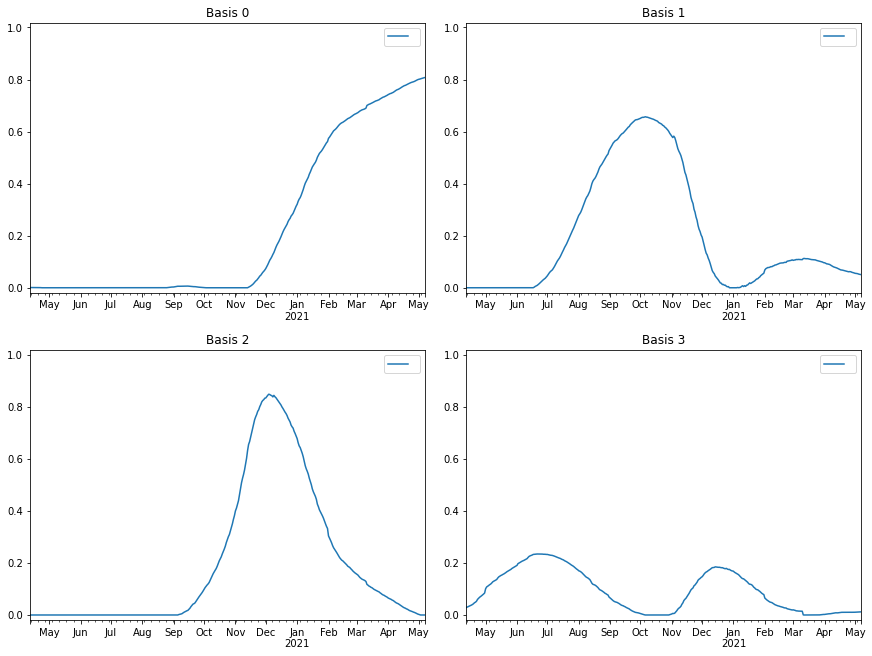

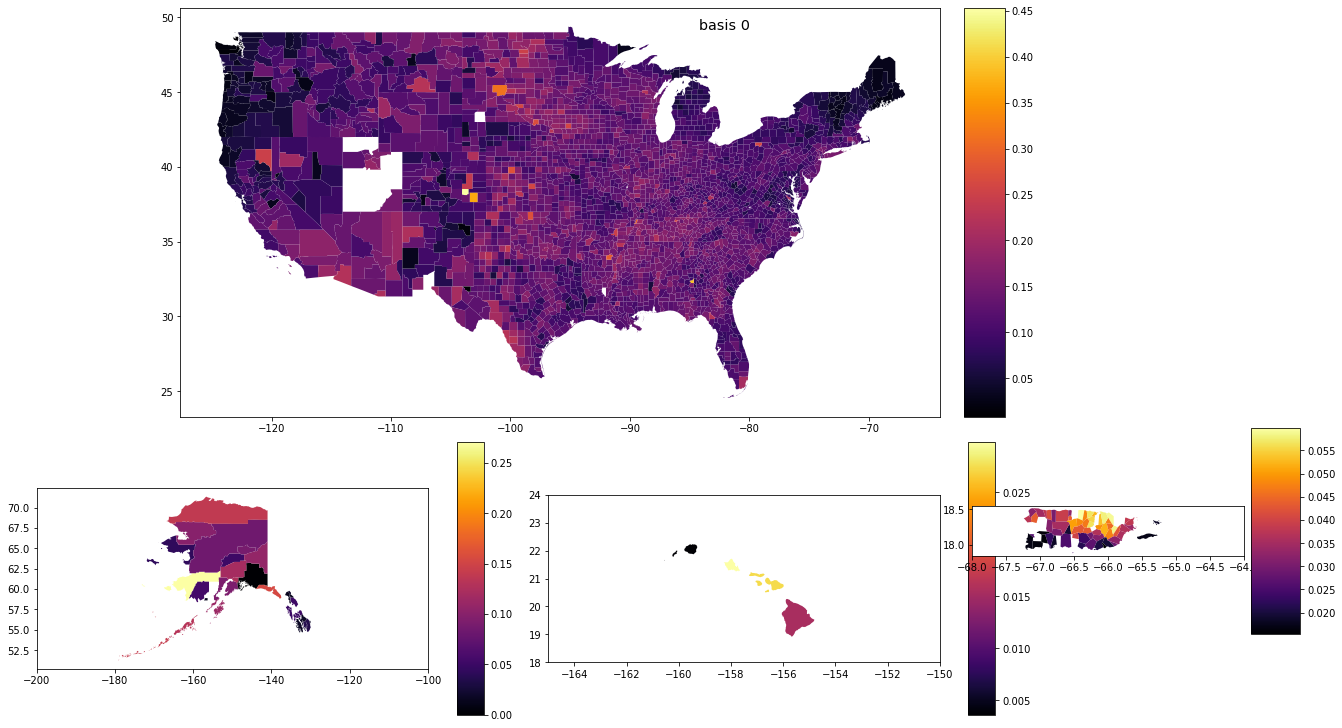

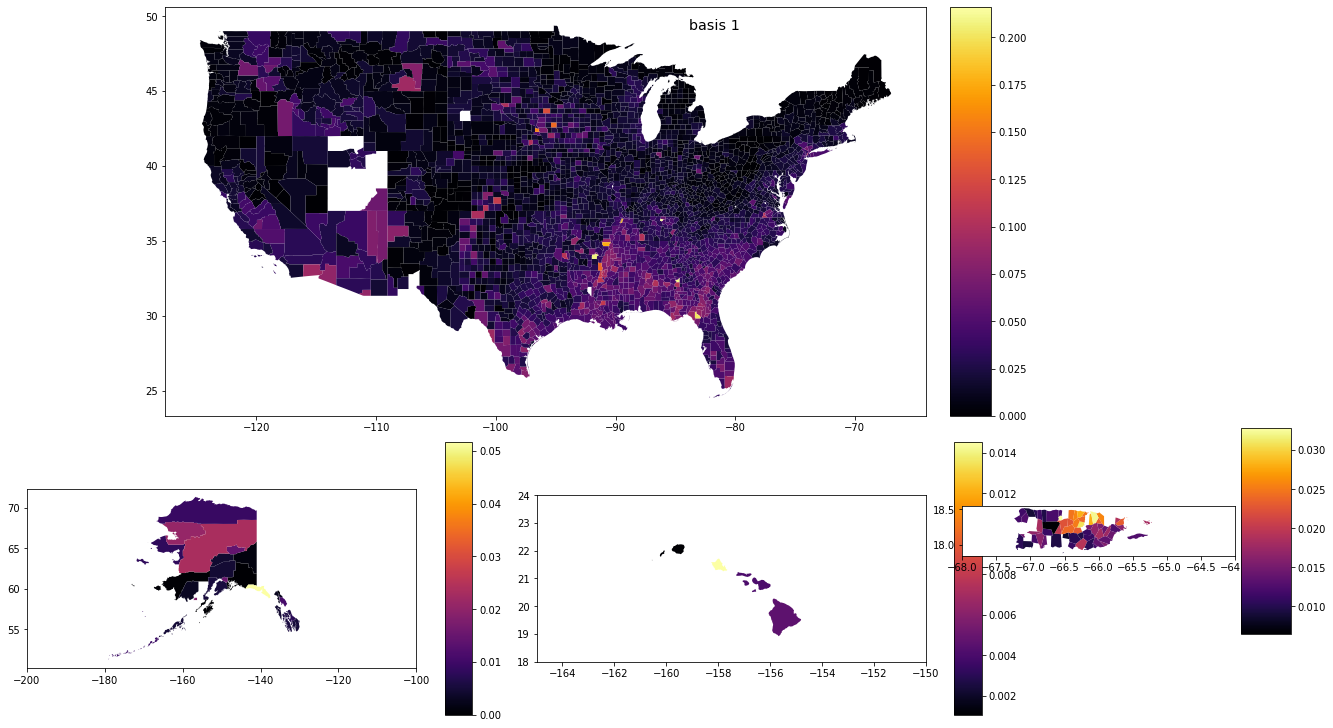

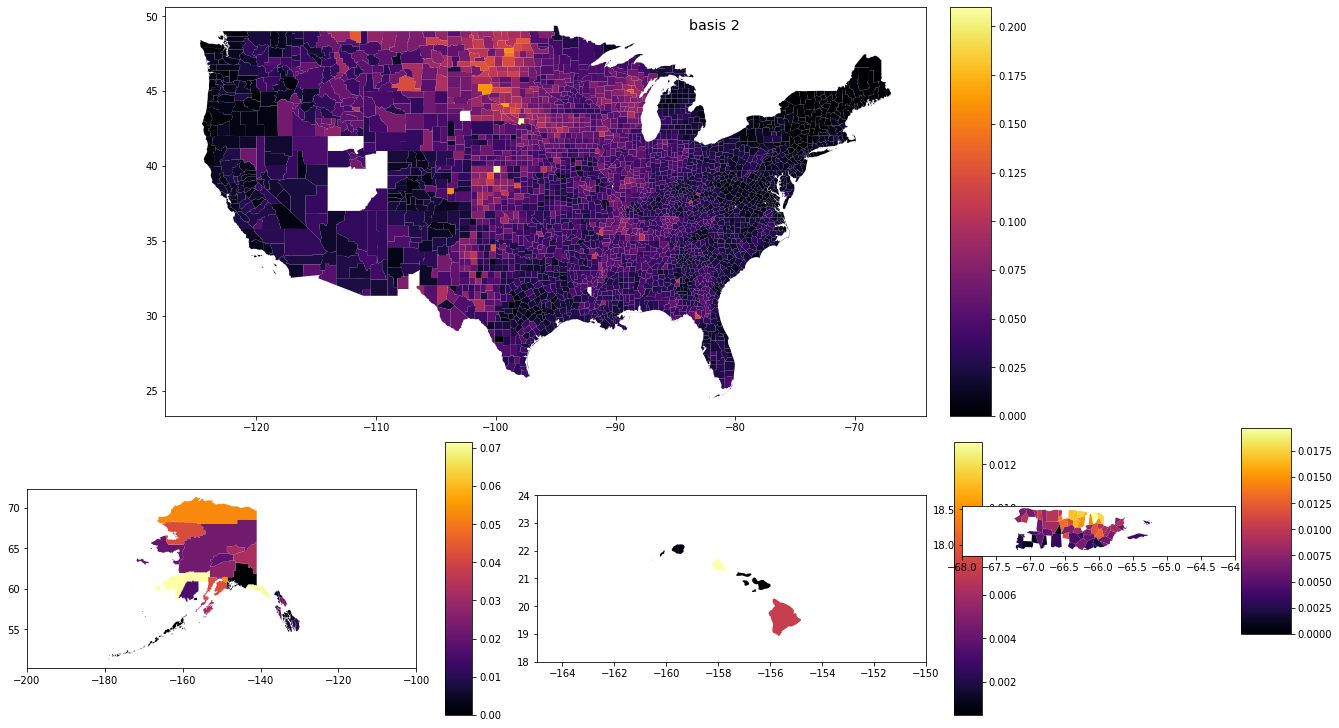

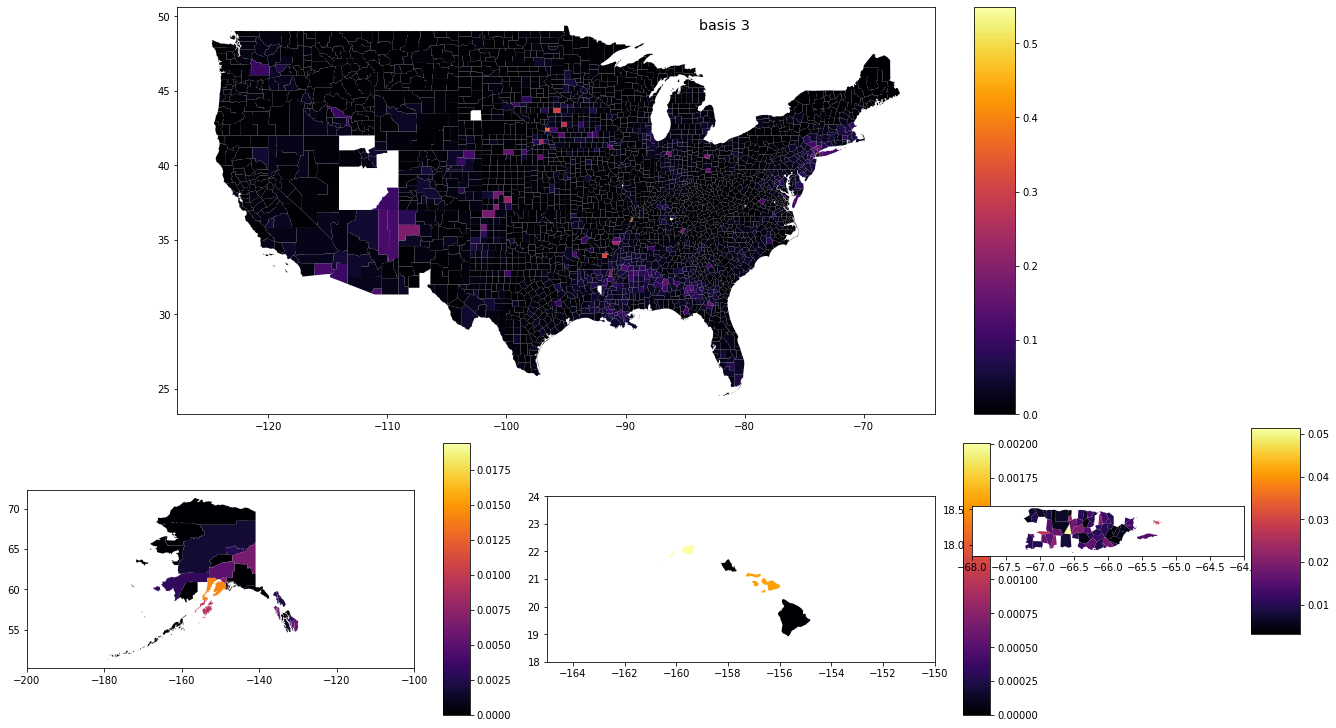

In [22]:
clus.basis_vectors()
clus.county_map_basis()

### Make the graph

In [13]:
surge_searcher = clus.y_table

In [14]:
surge_searcher.columns = county_norm.dataframe.columns

In [15]:
county_graph = make_graph()

In [16]:
for c in county_graph.V.keys():
    try:
        surges = surge_searcher.loc[:, (c[0], c[1], county_graph.V[c].geo_id)]
        for s in range(len(surges)):
            county_graph.V[c].surge_vals[surges.index[s]] = surges[surges.index[s]]
    except:
        print(c)

In [17]:
for k in county_graph.V.keys():
    if county_graph.V[k].neighbors == {}:
        print(k)
    

('Hawaii', 'Hawaii')
('Hawaii', 'Honolulu')
('Hawaii', 'Kauai')
('Minnesota', 'Watonwan')
('Virginia', 'Fairfax City')


In [18]:
county_graph.V[('Virginia', 'Fairfax City')].surge_vals

{'basis 0': 0.027501583136689847,
 'basis 1': 0.008301505319489175,
 'basis 2': 0.003860430002903012,
 'basis 3': 0.010050838057632948}